<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
    
##  Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [2]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 50)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import re
sns.set_style("darkgrid")

In [3]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [4]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    ''' ВАШ КОД ЗДЕСЬ '''
    
    
    #Загрузка файлов пользователей
    files_paths = list(glob(os.path.join(path_to_csv_files,'user*.csv')))
    files = []
    user_IDs = []
    for path in tqdm_notebook(files_paths):
        f_name = os.path.split(path)[1]
        ID = int(re.findall("[0-9]+",f_name)[0])
        user_IDs.append(ID)
        files.append(pd.read_csv(path))
    user_IDs = np.array(user_IDs)
            
    #Получение словаря сайтов с ID и частотами
    if (session_length==10) and (window_size==10):#если так, то подгружаем уже готовый
        with open(site_freq_path,'rb') as f:
            sites_dict_sorted = pickle.load(f)
        f.close()
    else:        #иначе создаем из файлов пользователй
        sites_dictionary = {}
        
        for user in tqdm_notebook(files):
            for site in user.site.values:
                if site in sites_dictionary:
               
                    sites_dictionary[site] += 1                
                
                else:
                    sites_dictionary[site] = 1
              
        d =  sorted(sites_dictionary.items(), key=lambda item: item[1],reverse = True)    
        sites_dict_sorted = {}
    
        for ii,pair in enumerate(d):
        
            sites_dict_sorted[pair[0]] = [ii+1,pair[1]]  #заполнение словаря ID и частотами из отсортированного d
            
    
    # Заполнение таблицы пользовательских сессий ID просмотренных пользователем сайтов
    Session_list = []  
    
    for ind,user in enumerate(tqdm_notebook(files)): 
        session = np.zeros(len(feature_names))
        session[-1] = user_IDs[ind] #заполнение столбца ID пользователей
         
        sites = user.site.values
        user.timestamps = pd.to_datetime(user.timestamp)#Столбец даты и времени начала просмотра сайта
        weekdays = user.timestamps.apply(lambda x:x.weekday()).values
        hours = user.timestamps.apply(lambda x:x.time().hour).values
        seconds = user.timestamps.apply(lambda x:x.timestamp()).values
        
               
        session[-2] = weekdays[0] # день недели просмотра сайта
        session[-3] = hours[0] # час просмотра сайта
        
        ufile_length = sites.shape[0]
        site_position = 0 #начальная позиция в сессии
        pos_in_ufile = 0 #начальная позиция в файле
        while pos_in_ufile < ufile_length: 
            session[site_position]=sites_dict_sorted[sites[pos_in_ufile]][0]#получение ID сайта из словаря по названию
            if site_position > 0:
                session[site_position + session_length-1] = seconds[pos_in_ufile] -\
                                                            seconds[pos_in_ufile-1] #время просмотра сайта
            pos_in_ufile += 1 #шаг по файлу
            site_position += 1 #шаг по сессии
        
            if site_position == session_length: #если достигнут конец сессии
                session[-4] = np.unique(session[:session_length]).shape[0] #Количество уникальных сайтов в сессии
                session[-5] = seconds[pos_in_ufile-1] -\
                                seconds[pos_in_ufile-session_length]          #длительность сессии   
                Session_list.append(session) #готовая сессия добавляется в список
                
                session = np.zeros(len(feature_names))#инициализируется новая сессия
                session[-1] = user_IDs[ind]
                site_position = 0
                pos_in_ufile -= session_length - window_size
                if (pos_in_ufile != ufile_length):#если не достигнут конец файла
                    session[-2] = weekdays[pos_in_ufile]
                    session[-3] = hours[pos_in_ufile]
                
            
            
            if (pos_in_ufile == ufile_length) & (site_position != 0):#если файл закончился раньше сессии
                    
                session[-4] = np.unique(session[:site_position]).shape[0] 
                session[-5] = seconds[pos_in_ufile-1]-\
                                    seconds[pos_in_ufile-site_position]                  
                Session_list.append(session)
                
                if site_position > window_size:#если каретка вышла за пределы окна (можно начать новую сессию)
                    session = np.zeros(len(feature_names))
                    session[-1] = user_IDs[ind]               
                    pos_in_ufile -= site_position - window_size
                    site_position = 0 
                    session[-2] = weekdays[pos_in_ufile]
                    session[-3] = hours[pos_in_ufile]
    
    
    Sessions = pd.DataFrame(Session_list,columns=feature_names, dtype = int)
        
       
    return Sessions  

**Проверим функцию на игрушечном примере.**

In [5]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10,window_size=10)

In [6]:
train_data_toy

site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0      3      2      2      7      2      1      8      5      9      10   
1      3      1      1      1      0      0      0      0      0       0   
2      3      2      6      6      2      0      0      0      0       0   
3      4      1      2      1      2      1      1      5     11       4   
4      4      1      2      0      0      0      0      0      0       0   

   time_diff1  time_diff2  time_diff3  time_diff4  time_diff5  time_diff6  \
0         287        1184        6278         186           2           1   
1           2           3          55           0           0           0   
2         287        1184        6278         186           0           0   
3         287        1184        6278         186           2           1   
4         287        1184           0           0           0           0   

   time_diff7  time_diff8  time_diff9  session_timespan  #unique_sites  \
0           2           3          55              7998              8   
1           0           0           0                60              2   
2           0           0           0              7935              3   
3           2           3          55              7998              5   
4           0           0           0              1471              3   

   start_hour  day_of_week  target  
0           9            4       1  
1          12            4       1  
2           9            4       2  
3           9            4       3  
4          12            4       3

**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [7]:
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

In [8]:
%%time
#Проверка времени работы и числа сессий(относительно данных из предыдущей недели), не испорчен ли функционал
check = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=5, window_size=5)


Wall time: 4.72 s


In [9]:
check.shape #соотвествует правильному ответу из предыдущей недели

(28118, 24)

In [10]:
train_data_10users.head()

site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0    192    574    133      3    133    133      3    133    203     133   
1    415    193    674    254    133     31    393   3305    217      55   
2     55      3     55     55      5    293    415    333    897      55   
3    473   3306    473     55     55     55     55    937    199     123   
4    342     55      5   3307    258    211   3308   2086    675    2086   

   time_diff1  time_diff2  time_diff3  time_diff4  time_diff5  time_diff6  \
0          10           0           0           1          20           1   
1           1           0         163         105           0           1   
2           0          14           1         242           0           0   
3           2           1           0           1          25           1   
4           1           0           1           1           1           0   

   time_diff7  time_diff8  time_diff9  session_timespan  #unique_sites  \
0           0           1           0                33              5   
1           3           3           8               284             10   
2           1           0           0               258              7   
3           0           0           0                30              6   
4           1           1           0                 6              9   

   start_hour  day_of_week  target  
0           8            4      31  
1           8            4      31  
2           8            4      31  
3           8            4      31  
4           8            4      31

**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [11]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10, window_size=10)
train_data_150users


Wall time: 37.4 s


site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0           1      1      4      2      1      4      1      2   1290     321   
1           2     23   1505   1290    321    321    113     73     49      49   
2         321    205      1      1      1      1     73    321      2       1   
3           1      1   6998   6998   5491   6998   6998      1     35       1   
4           1      1     76      1     58     50     58     50     83      76   
5          50     58     94     92     50     76     76     83     92      50   
6          58     94     58     92     76     83     50     94     94      76   
7          83     50     58     92     58     94     50     50     76      58   
8          94     76     83     50     92     58   6998     76     50      58   
9          94     92     76     58     50     92     94     50     58      83   
10         94     76     50     83     58     92     50     94     58      92   
11         94     83     92     58     50    219     92     94     58      83   
12         76    233    233     50    219     58    233     58    233      50   
13        219     83     76     50     92     94     92     76     58      50   
14         94     83     94     92     92     92     58     92     58      50   
15         94     76     92     83     50    353      1      4      2       1   
16          4      2      1      1      2      4      1      2      4       1   
17          1      4      2      1      2      1      4     14     46      14   
18         51      2     14      1      8      4     14     46     51       1   
19          4      8      7      7     42      2      8     14      7      56   
20         42      8    192      8      4      7     14      8     56       7   
21          8    192      7      1      2      4      1      2      1       4   
22          1      1      1      4      1      2      1      1    603       4   
23          2    603    603      1      1      1      2      4      1       1   
24          1      4      2      1      1      2      4      1      1       1   
25          2      4    603      1      1      2      4      1      4       2   
26          1      1    603    603      1      1      1    485      1    2923   
27        852   2923      1      2      4      1   1290      1     23    1505   
28          2    321      1     23      1      1      2      4      4       2   
29          2      1      1      1   3147     12    982     33    881       1   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
136989    306     66    154    333     66      3     66     16     13     333   
136990    341   1153    341     84     11     12    341   2777    333     333   
136991    333    341   1424    341    306   1236    333   1236    306     760   
136992    130     12     62     66    760    306    827    341    306    1424   
136993     66     66    306     66    341    306    306    341     66     154   
136994     12    333      3     16     13    341   1236    333    306     760   
136995    306     12    130     66    306    760    341    306    333      66   
136996    306     66    333      2    306     66   1424    341      1     306   
136997     62     66    341     31    341    333    306   6997     12      66   
136998   6997      8     13     16      3    341   1424    341   1236      14   
136999     12   1236   1424    341    306    760     12     84    130      66   
137000    341    760    306   1236    306   1236     62    341    760     306   
137001     12     66    306    760    341    306     66    130     62      84   
137002    429     66     10     28   4136   3039      3     12   4136    2902   
137003     10     66     28     66   3995      3     66    306    306       2   
137004     28    341    306     66    154    333     28     17    306     341   
137005     10    306     13     16    306      3     66     66    322     306   
137006     66     66    341    154    3

**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [12]:
new_features_10users = train_data_10users[["session_timespan", "#unique_sites", "start_hour", "day_of_week" ]]
new_features_150users = train_data_150users[["session_timespan", "#unique_sites", "start_hour", "day_of_week" ]]

In [13]:
PATH_TO_result = 'capstone_user_identification//result_w3'

In [14]:
with open(os.path.join(PATH_TO_result, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_result, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [15]:
''' ВАШ КОД ЗДЕСЬ ''' 
new_features_10users.session_timespan.median()

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [16]:
''' ВАШ КОД ЗДЕСЬ ''' 
new_features_10users.day_of_week.median()

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [17]:
''' ВАШ КОД ЗДЕСЬ ''' 
new_features_150users.start_hour.median()

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [18]:
''' ВАШ КОД ЗДЕСЬ ''' 
new_features_150users['#unique_sites'].median()

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [19]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [20]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

In [21]:
train_data_10users.head()

site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0    192    574    133      3    133    133      3    133    203     133   
1    415    193    674    254    133     31    393   3305    217      55   
2     55      3     55     55      5    293    415    333    897      55   
3    473   3306    473     55     55     55     55    937    199     123   
4    342     55      5   3307    258    211   3308   2086    675    2086   

   time_diff1  time_diff2  time_diff3  time_diff4  time_diff5  time_diff6  \
0          10           0           0           1          20           1   
1           1           0         163         105           0           1   
2           0          14           1         242           0           0   
3           2           1           0           1          25           1   
4           1           0           1           1           1           0   

   time_diff7  time_diff8  time_diff9  session_timespan  #unique_sites  \
0           0           1           0                33              5   
1           3           3           8               284             10   
2           1           0           0               258              7   
3           0           0           0                30              6   
4           1           1           0                 6              9   

   start_hour  day_of_week target  
0           8            4   John  
1           8            4   John  
2           8            4   John  
3           8            4   John  
4           8            4   John

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

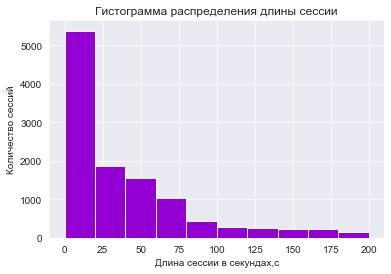

In [22]:
''' ВАШ КОД ЗДЕСЬ '''
plt.hist(train_data_10users['session_timespan'],color='darkviolet',range = (0,200))

plt.xlabel('Длина сессии в секундах,с')
plt.ylabel('Количество сессий')
plt.title('Гистограмма распределения длины сессии')

plt.grid(True)
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

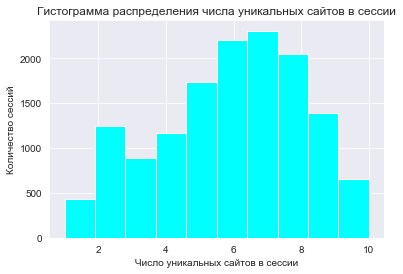

In [23]:
plt.hist(train_data_10users['#unique_sites'],color='aqua')  
plt.xlabel('Число уникальных сайтов в сессии')
plt.ylabel('Количество сессий')
plt.title('Гистограмма распределения числа уникальных сайтов в сессии')
plt.grid(True)
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

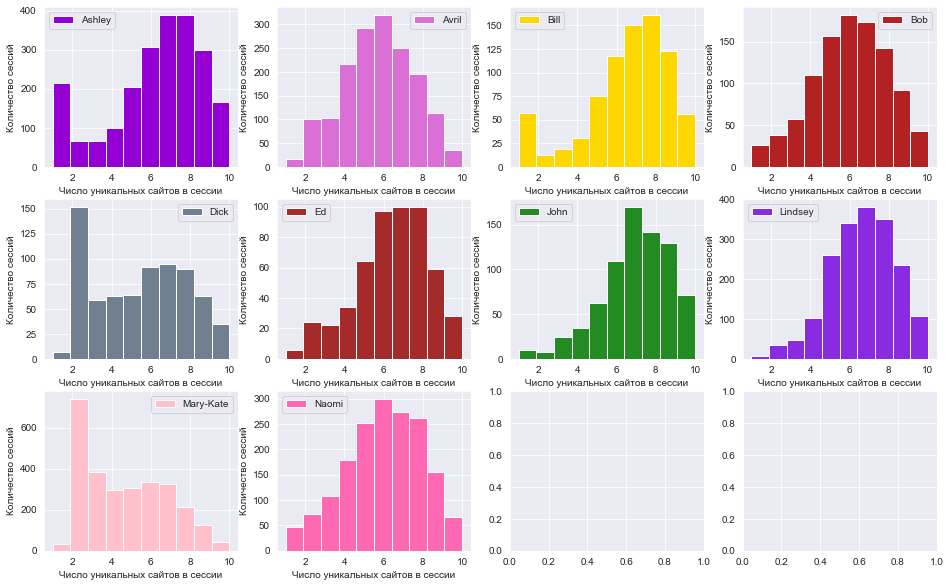

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx,(user,sub_df) in enumerate(train_data_10users.groupby('target')):
    ax = axes[idx // 4,idx % 4]
    ax.hist(sub_df['#unique_sites'],color=color_dic[user])  
    ax.set(xlabel='Число уникальных сайтов в сессии', ylabel='Количество сессий')
    ax.legend([user])
    plt.grid(True)


**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

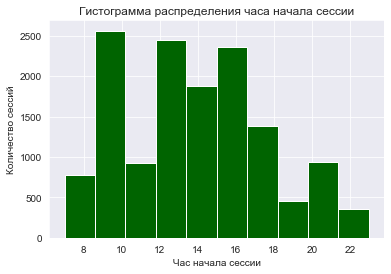

In [25]:
plt.hist(train_data_10users['start_hour'],color='darkgreen')
plt.xlabel('Час начала сессии')
plt.ylabel('Количество сессий')
plt.title('Гистограмма распределения часа начала сессии')
plt.grid(True)

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

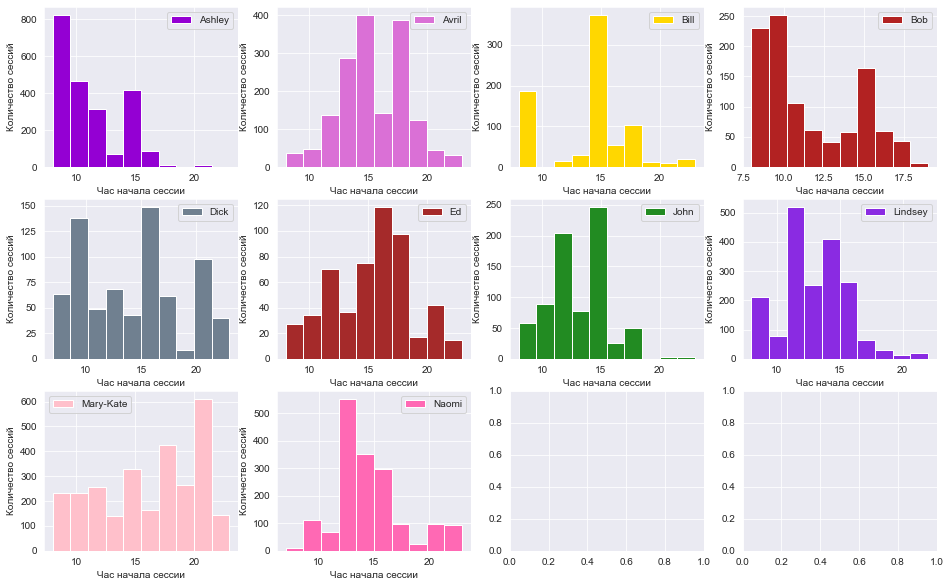

In [26]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
    ax = axes[idx // 4,idx % 4]
    ax.hist(sub_df.start_hour,color = color_dic[user])
    ax.set(xlabel = 'Час начала сессии',ylabel = 'Количество сессий')
    ax.legend([user])
    ax.grid(True)


**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

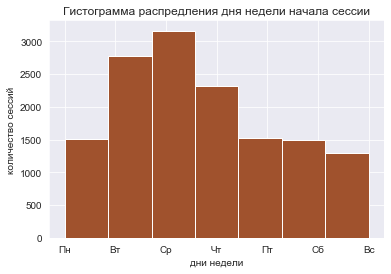

In [27]:
plt.hist(train_data_10users['day_of_week'], color = 'sienna',bins=train_data_10users['day_of_week'].unique().shape[0])
plt.xlabel('дни недели')
plt.ylabel('количество сессий')
plt.title('Гистограмма распредления дня недели начала сессии')
plt.xticks(np.linspace(0,6,7),['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

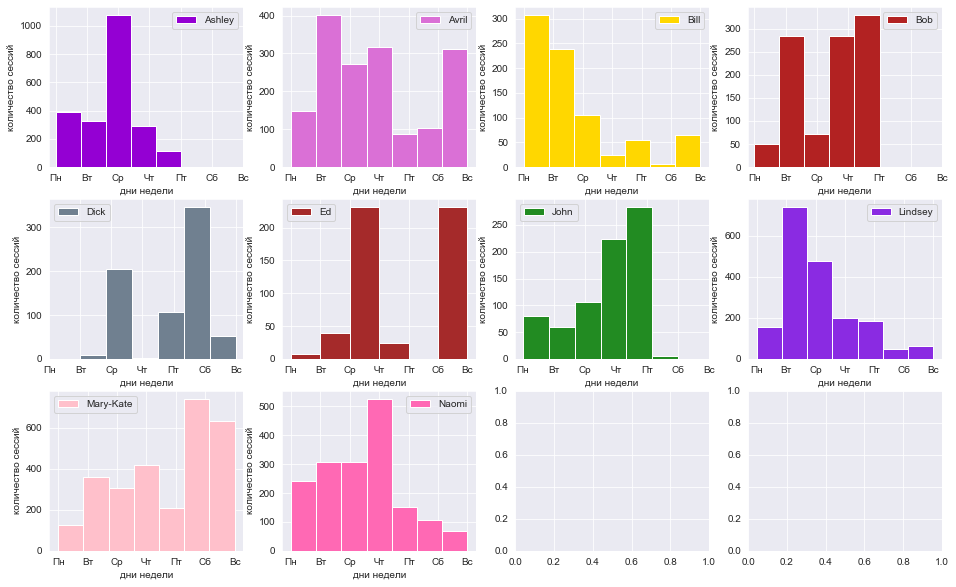

In [28]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))


for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
    ax = axes[idx//4,idx%4]    
    ax.hist(sub_df.day_of_week,color = color_dic[user],bins = sub_df.day_of_week.unique().shape[0])
    ax.set(xlabel='дни недели',ylabel='количество сессий')
    ax.set_xticks(range(7))
    ax.set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] )
    ax.grid(True)
    ax.legend([user])
    

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

**По уникальным сайтам в сессии**

'Ashley': в среднем больше половины уникальных сайтов в сессии;

'Avril': в среднем около половины уникальных сайтов в сессии;

'Bill': в среднем больше половины уникальных сайтов в сессии;

'Bob': в среднем около половины уникальных сайтов в сессии;

'Dick': есть много сессий, где встречается 6-8 уникальных сайтов,чуть меньше 3-5, при этом выделяется количество уникальных сайтов - 2 (150 сессий);

'Ed': в среднем несколько больше половины уникальных сайтов в сессии;

'John': в среднем больше половины уникальных сайтов в сессии;

'Lindsey': в среднем больше половины уникальных сайтов в сессии;

'Mary-Kate': есть много сессий, где встречается 3-7 уникальных сайтов,чуть меньше 8-9, при этом выделяется количество уникальных сайтов 2 (больше 700 сессий);

'Naomi': в среднем несколько больше половины уникальных сайтов в сессии.


**По времени активности пользователя**

'Ashley': основная активность утром;

'Avril': основная активность в середине дня;

'Bill': основная активность в районе 15 часов, но есть и явная активность утром;

'Bob': основная активность утром, но есть и явная активность в районе 15 часов;

'Dick': выделяются утро (10), день (15) и вечер (20);

'Ed': основная активность примерно с 15 - 18 часов;

'John': основная активность утром примерно в 11 и днем примерно в 15, вечером (после 18) нет активности;

'Lindsey': основная активности с 10 до 16 (примерно) в остальное время, кроме утра, активность малая;

'Mary-Kate': основна активность вечером в районе 20;

'Naomi': осноная активность в районе 12-13.

**По дням недели**

'Ashley': основная активность в среду, в выходные нет активности;

'Avril': слабая активность в пн, пт, сб, в остальные дни активность сильная;

'Bill': основная активность пн-ср;

'Bob': основная активность вт,чт,пт, в выходные нет;

'Dick': основная активность ср, сб, а в пн и чт - нет активности;

'Ed': основная активность ср, вс,а в сб нет активности;

'John': основная активность в чт, пт, при этом в вскр нет активности, в сб почти нет;

'Lindsey': основная активность вт, ср;

'Mary-Kate': основная активность в выходные;

'Naomi': основная активность в чт, а выходные активность слабая.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [29]:
with open (os.path.join(PATH_TO_DATA,'site_freq_10users.pkl'),'rb') as f:
    site_freq_10users = pickle.load(f)
f.close()

In [31]:
site_freq_10users

{'s.youtube.com': [1, 8300],
 'www.google.fr': [2, 7813],
 'www.google.com': [3, 5441],
 'mail.google.com': [4, 4158],
 'www.facebook.com': [5, 4141],
 'apis.google.com': [6, 3758],
 'r3---sn-gxo5uxg-jqbe.googlevideo.com': [7, 3244],
 'r1---sn-gxo5uxg-jqbe.googlevideo.com': [8, 3094],
 'plus.google.com': [9, 2630],
 'accounts.google.com': [10, 2089],
 'r2---sn-gxo5uxg-jqbe.googlevideo.com': [11, 1939],
 'fr-mg42.mail.yahoo.com': [12, 1868],
 'www.youtube.com': [13, 1804],
 'r4---sn-gxo5uxg-jqbe.googlevideo.com': [14, 1702],
 'clients1.google.com': [15, 1493],
 'download.jboss.org': [16, 1441],
 's-static.ak.facebook.com': [17, 1388],
 'static.ak.facebook.com': [18, 1265],
 'i1.ytimg.com': [19, 1232],
 'twitter.com': [20, 1204],
 'accounts.youtube.com': [21, 1057],
 'platform.twitter.com': [22, 1041],
 'clients6.google.com': [23, 1039],
 'safebrowsing-cache.google.com': [24, 1039],
 'translate.google.fr': [25, 1002],
 'api.twitter.com': [26, 982],
 'accounts.google.fr': [27, 974],
 'tal

In [32]:
len(site_freq_10users)

4913

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [33]:
df_freq = pd.DataFrame(site_freq_10users).T
df_freq.columns = ['id','freq']
df_freq.head(10)

id  freq
s.youtube.com                          1  8300
www.google.fr                          2  7813
www.google.com                         3  5441
mail.google.com                        4  4158
www.facebook.com                       5  4141
apis.google.com                        6  3758
r3---sn-gxo5uxg-jqbe.googlevideo.com   7  3244
r1---sn-gxo5uxg-jqbe.googlevideo.com   8  3094
plus.google.com                        9  2630
accounts.google.com                   10  2089

In [34]:
top10_freqs = list(df_freq[df_freq.id <= 10].freq)
top10_sites = list(df_freq[df_freq.id <= 10].index)

In [35]:
print(top10_sites)
print(top10_freqs)

['s.youtube.com', 'www.google.fr', 'www.google.com', 'mail.google.com', 'www.facebook.com', 'apis.google.com', 'r3---sn-gxo5uxg-jqbe.googlevideo.com', 'r1---sn-gxo5uxg-jqbe.googlevideo.com', 'plus.google.com', 'accounts.google.com']
[8300, 7813, 5441, 4158, 4141, 3758, 3244, 3094, 2630, 2089]


**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

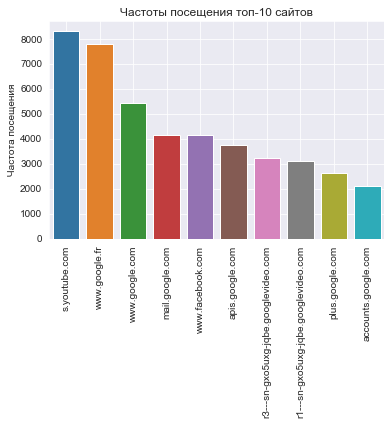

In [36]:
sns.barplot(top10_sites,top10_freqs)
plt.ylabel('Частота посещения')

plt.title('Частоты посещения топ-10 сайтов')
plt.xticks(rotation=90)
plt.grid(True)


plt.show()

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [37]:
def feature_engineering(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    ''' ВАШ КОД ЗДЕСЬ '''
    
    
    #Загрузка файлов пользователей
    files_paths = list(glob(os.path.join(path_to_csv_files,'user*.csv')))
    files = []
    user_IDs = []
    for path in tqdm_notebook(files_paths):
        f_name = os.path.split(path)[1]
        ID = int(re.findall("[0-9]+",f_name)[0])
        user_IDs.append(ID)
        files.append(pd.read_csv(path))
    user_IDs = np.array(user_IDs)
            
    #Получение словаря сайтов с ID и частотами
    if (session_length==10) and (window_size==10):#если так, то подгружаем уже готовый
        with open(site_freq_path,'rb') as f:
            sites_dict_sorted = pickle.load(f)
        f.close()
    else:        #иначе создаем из файлов пользователй
        sites_dictionary = {}
        
        for user in tqdm_notebook(files):
            for site in user.site.values:
                if site in sites_dictionary:
               
                    sites_dictionary[site] += 1                
                
                else:
                    sites_dictionary[site] = 1
              
        d =  sorted(sites_dictionary.items(), key=lambda item: item[1],reverse = True)    
        sites_dict_sorted = {}
    
        for ii,pair in enumerate(d):
        
            sites_dict_sorted[pair[0]] = [ii+1,pair[1]]  #заполнение словаря ID и частотами из отсортированного d
            
    
    # Заполнение таблицы пользовательских сессий ID просмотренных пользователем сайтов
    Session_list = []  
    
    for ind,user in enumerate(tqdm_notebook(files)): 
        session = np.zeros(len(feature_names))
        session[-1] = user_IDs[ind] #заполнение столбца ID пользователей
         
        sites = user.site.values
        user.timestamps = pd.to_datetime(user.timestamp)#Столбец даты и времени начала просмотра сайта
        weekdays = user.timestamps.apply(lambda x:x.weekday()).values
        hours = user.timestamps.apply(lambda x:x.time().hour).values
        seconds = user.timestamps.apply(lambda x:x.timestamp()).values
        
               
        session[-2] = weekdays[0] # день недели просмотра сайта
        session[-3] = hours[0] # час просмотра сайта
        
        ufile_length = sites.shape[0]
        site_position = 0 #начальная позиция в сессии
        pos_in_ufile = 0 #начальная позиция в файле
        while pos_in_ufile < ufile_length: 
            session[site_position]=sites_dict_sorted[sites[pos_in_ufile]][0]#получение ID сайта из словаря по названию
            if site_position > 0:
                session[site_position + session_length-1] = seconds[pos_in_ufile] -\
                                                            seconds[pos_in_ufile-1] #время просмотра сайта
            
            
            
            #ДОБАВЛЕННЫЕ ПРИЗНАКИ (дабавляются с конца списка признаков и после уже известных)
            
            site_id = int(session[site_position])
            dict_len = len(sites_dict_sorted)
            
                
            #Время просмотра одного из топ-30 сайтов словаря
            if site_position > 0:
                if site_id <= 30:
                    
                    session[-5 - 31 + site_id] += seconds[pos_in_ufile] -\
                                                            seconds[pos_in_ufile-1]   
            
            
            # Индикаторы посещения топ-30 сайтов из словаря
            if site_id <= 30:
                if session[-5 - 61 + site_id] == 0:
                    session[-5 - 61 + site_id] = 1 
            
            
            
            #ПРИЗНАКИ на основе предпочтений посещения сайтов (частоты)
            
            #Частоты посещения 10 не самых популярных, но более специфичных сайтов, чем лидеры
            if (site_id <= dict_len//50) and (site_id > (dict_len//50)-10):
                position10 = site_id - (dict_len//50-10) #позиция признака по порядку следования (1...10)
                session[-5 - 71 + position10] += 1 #увеличивается частота посещения
            
            #Частоты посещения 10  самых популярных сайтов
            if site_id <= 10:                
                session[-5 - 81 + site_id] += 1 #увеличивается частота посещения       
                     
           
            
            #конец составления добавочных признаков
                
            
            pos_in_ufile += 1 #шаг по файлу
            site_position += 1 #шаг по сессии
        
            if site_position == session_length: #если достигнут конец сессии
                session[-4] = np.unique(session[:session_length]).shape[0] #Количество уникальных сайтов в сессии
                session[-5] = seconds[pos_in_ufile-1] -\
                                seconds[pos_in_ufile-session_length]     #длительность сессии        
                Session_list.append(session) #готовая сессия добавляется в список
                
                session = np.zeros(len(feature_names))#инициализируется новая сессия
                session[-1] = user_IDs[ind]
                site_position = 0
                pos_in_ufile -= session_length - window_size
                if (pos_in_ufile != ufile_length):#если не достигнут конец файла
                    session[-2] = weekdays[pos_in_ufile]
                    session[-3] = hours[pos_in_ufile]
                
            
            
            if (pos_in_ufile == ufile_length) & (site_position != 0):#если файл закончился раньше сессии
                    
                session[-4] = np.unique(session[:site_position]).shape[0] 
                session[-5] = seconds[pos_in_ufile-1]-\
                                    seconds[pos_in_ufile-site_position]                  
                Session_list.append(session)
                
                if site_position > window_size:#если каретка вышла за пределы окна (можно начать новую сессию)
                    session = np.zeros(len(feature_names))
                    session[-1] = user_IDs[ind]               
                    pos_in_ufile -= site_position - window_size
                    site_position = 0 
                    session[-2] = weekdays[pos_in_ufile]
                    session[-3] = hours[pos_in_ufile]
    
    
    Sessions = pd.DataFrame(Session_list,columns=feature_names, dtype = int)
        
       
    return Sessions  

In [38]:
feature_names1 = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(i) for i in range(1,10)] + \
                ['freq__top10_' + str(i) for i in range(1,11)] + \
                ['freq__mid10_' + str(i) for i in range(1,11)] + \
                ['ind_top'+str(i) for i in range(1,31)]+\
                ['time_top'+str(i) for i in range(1,31)]+\
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']

In [39]:
train10users_many_fe = feature_engineering(os.path.join(PATH_TO_DATA, '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                  feature_names=feature_names1, session_length=10, window_size=10)
train10users_many_fe

site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0        192    574    133      3    133    133      3    133    203     133   
1        415    193    674    254    133     31    393   3305    217      55   
2         55      3     55     55      5    293    415    333    897      55   
3        473   3306    473     55     55     55     55    937    199     123   
4        342     55      5   3307    258    211   3308   2086    675    2086   
5        226    675    211    211     55     55    128    172   3309    3310   
6        350    574    133      3    133     31    133    393    192     133   
7        262   3311   1550    393     55      3     55      3    199     123   
8         55    333    106    203   1243    513     55    809    106       5   
9       1007    350   3312    350   3313    534    601    601    534     602   
10       602    172    172    463      2      2      6      3      2    2575   
11      2575   3314   3315   2087    160    160    117     90      2      90   
12       108    561    603     18     44    108    384     17     90    2088   
13        90    733      5    101     22   1244   1244     90    561      31   
14        20     31     20     90      5    117      6      3      2       2   
15        54      2     62     86     54     86     62     54     62     142   
16        54     62     54    142     61     61     61     61    366     310   
17       310    366    310   1072    366   1373   1373   1072    310     366   
18        98     98    310    366   2576    310   1245   1152   1245     310   
19      2576   1152   1245   1245    310    366    310    366   1152     310   
20       366    366   1373      3    310    366      2   1373    464    1779   
21       366    310      3    851    310      2    464    575    851     366   
22       310    851    310    575   1072    366    851    310    575    1780   
23      2089    366    310    464    851    851    310    464    575     464   
24       575    310    575   2090    810    575    310    575    851     464   
25       575    366    310    464    575    464    310    464    575     575   
26       851    464    464    464    193    464    674    464    342     128   
27       464    464    464    575    464    293    575   1374     43     463   
28         2      2      3      6      2   1781    245   1781    588    1782   
29       128    203   1374    212      5    588   1781    513   1551     588   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
14031     67    577     67    537     37     24     24     85     52     242   
14032    242    242     37     24     24    254     24     37     37      24   
14033     37     24     24     37    112     72     15    138     15     266   
14034    454    454     67     52    218    421     24     37    454      37   
14035     24     24     37     24     37     24     15      2    463      72   
14036     15      2    527    527    527      2     58     58     31       3   
14037     58     31      2   1455      3     58    136      3   1455      58   
14038     58      3      5     15     58      2     18     17     36    1455   
14039     22     44      5     15      3     36    107     92     36       3   
14040     36    107     73     15     36    157     36    246     36      36   
14041    259      5    212    654      2    746    457    479    175      31   
14042    251    524    283    175    246     80    283     52    297     283   
14043    172    369     20    119      3      2      6     10    105    4913   
14044   1625   1625     44     17      5   1625     18   1625   1008    1008   
14045   2245     19     85    498    285    285     24     37     37      24   
14046     69     69    161     24     37     72     15      2      2      15   
14047     15     15     15     15    138    112    266    454     67     218   
14048    421    218      2     65     21     27      6     10      3      30   
14049  

Посмотрим на признаки в табличной форме

In [40]:
train10users_many_fe[['freq__top10_' + str(i) for i in range(1,11)]].head()

freq__top10_1  freq__top10_2  freq__top10_3  freq__top10_4  freq__top10_5  \
0              0              0              2              0              0   
1              0              0              0              0              0   
2              0              0              1              0              1   
3              0              0              0              0              0   
4              0              0              0              0              1   

   freq__top10_6  freq__top10_7  freq__top10_8  freq__top10_9  freq__top10_10  
0              0              0              0              0               0  
1              0              0              0              0               0  
2              0              0              0              0               0  
3              0              0              0              0               0  
4              0              0              0              0               0

In [41]:
train10users_many_fe[['freq__mid10_' + str(i) for i in range(1,11)]].head()

freq__mid10_1  freq__mid10_2  freq__mid10_3  freq__mid10_4  freq__mid10_5  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   freq__mid10_6  freq__mid10_7  freq__mid10_8  freq__mid10_9  freq__mid10_10  
0              0              0              0              0               0  
1              0              0              0              0               0  
2              0              0              0              0               0  
3              0              0              0              0               0  
4              0              0              0              0               0

In [42]:
train10users_many_fe[['time_diff' + str(i) for i in range(1,10)]].head()

time_diff1  time_diff2  time_diff3  time_diff4  time_diff5  time_diff6  \
0          10           0           0           1          20           1   
1           1           0         163         105           0           1   
2           0          14           1         242           0           0   
3           2           1           0           1          25           1   
4           1           0           1           1           1           0   

   time_diff7  time_diff8  time_diff9  
0           0           1           0  
1           3           3           8  
2           1           0           0  
3           0           0           0  
4           1           1           0

In [43]:
train10users_many_fe[['ind_top'+str(i) for i in range(1,31)]].head()

ind_top1  ind_top2  ind_top3  ind_top4  ind_top5  ind_top6  ind_top7  \
0         0         0         1         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         1         0         1         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         1         0         0   

   ind_top8  ind_top9  ind_top10  ind_top11  ind_top12  ind_top13  ind_top14  \
0         0         0          0          0          0          0          0   
1         0         0          0          0          0          0          0   
2         0         0          0          0          0          0          0   
3         0         0          0          0          0          0          0   
4         0         0          0          0          0          0          0   

   ind_top15  ind_top16  ind_top17  ind_top18  ind_top19  ind_top20  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   ind_top21  ind_top22  ind_top23  ind_top24  ind_top25  ind_top26  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   ind_top27  ind_top28  ind_top29  ind_top30  
0          0          0          0          0  
1          0          0          0          0  
2          0          0          0          0  
3          0          0          0          0  
4          0          0          0          0

In [44]:
train10users_many_fe[['time_top'+str(i) for i in range(1,31)]].head()

time_top1  time_top2  time_top3  time_top4  time_top5  time_top6  \
0          0          0          1          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0        242          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   time_top7  time_top8  time_top9  time_top10  time_top11  time_top12  \
0          0          0          0           0           0           0   
1          0          0          0           0           0           0   
2          0          0          0           0           0           0   
3          0          0          0           0           0           0   
4          0          0          0           0           0           0   

   time_top13  time_top14  time_top15  time_top16  time_top17  time_top18  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   time_top19  time_top20  time_top21  time_top22  time_top23  time_top24  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   time_top25  time_top26  time_top27  time_top28  time_top29  time_top30  
0           0           0           0           0           0           0  
1           0           0           0           0           0           0  
2           0           0           0           0           0           0  
3           0           0           0           0           0           0  
4           0           0           0           0           0           0

In [45]:
# Выделим список дополнительных признаков
new_feat = ['time_diff' + str(i) for i in range(1,10)] + \
                ['freq__top10_' + str(i) for i in range(1,11)] + \
                ['freq__mid10_' + str(i) for i in range(1,11)] + \
                ['ind_top'+str(i) for i in range(1,31)]+\
                ['time_top'+str(i) for i in range(1,31)]+\
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week']

train10users_many_fe[new_feat].head()

time_diff1  time_diff2  time_diff3  time_diff4  time_diff5  time_diff6  \
0          10           0           0           1          20           1   
1           1           0         163         105           0           1   
2           0          14           1         242           0           0   
3           2           1           0           1          25           1   
4           1           0           1           1           1           0   

   time_diff7  time_diff8  time_diff9  freq__top10_1  freq__top10_2  \
0           0           1           0              0              0   
1           3           3           8              0              0   
2           1           0           0              0              0   
3           0           0           0              0              0   
4           1           1           0              0              0   

   freq__top10_3  freq__top10_4  freq__top10_5  freq__top10_6  freq__top10_7  \
0              2              0              0              0              0   
1              0              0              0              0              0   
2              1              0              1              0              0   
3              0              0              0              0              0   
4              0              0              1              0              0   

   freq__top10_8  freq__top10_9  freq__top10_10  freq__mid10_1  freq__mid10_2  \
0              0              0               0              0              0   
1              0              0               0              0              0   
2              0              0               0              0              0   
3              0              0               0              0              0   
4              0              0               0              0              0   

   freq__mid10_3  freq__mid10_4  freq__mid10_5  freq__mid10_6  ...  \
0              0              0              0              0  ...   
1              0              0              0              0  ...   
2              0              0              0              0  ...   
3              0              0              0              0  ...   
4              0              0              0              0  ...   

   time_top10  time_top11  time_top12  time_top13  time_top14  time_top15  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   time_top16  time_top17  time_top18  time_top19  time_top20  time_top21  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   time_top22  time_top23  time_top24  time_top25  time_top26  time_top27  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   time_top28  time_top29  time_top30  session_timespan  #unique_sites  \
0           0           0           0                33              5   
1           0           0           0               284             10   
2           0           0           0               258              7   
3           0           0           0  

In [47]:
new_features_10users = train10users_many_fe[new_feat]

Построим признаки для 150 пользователей

In [48]:
train150users_many_fe = feature_engineering(os.path.join(PATH_TO_DATA, '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                  feature_names=feature_names1, session_length=10, window_size=10)
train150users_many_fe

site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0           1      1      4      2      1      4      1      2   1290     321   
1           2     23   1505   1290    321    321    113     73     49      49   
2         321    205      1      1      1      1     73    321      2       1   
3           1      1   6998   6998   5491   6998   6998      1     35       1   
4           1      1     76      1     58     50     58     50     83      76   
5          50     58     94     92     50     76     76     83     92      50   
6          58     94     58     92     76     83     50     94     94      76   
7          83     50     58     92     58     94     50     50     76      58   
8          94     76     83     50     92     58   6998     76     50      58   
9          94     92     76     58     50     92     94     50     58      83   
10         94     76     50     83     58     92     50     94     58      92   
11         94     83     92     58     50    219     92     94     58      83   
12         76    233    233     50    219     58    233     58    233      50   
13        219     83     76     50     92     94     92     76     58      50   
14         94     83     94     92     92     92     58     92     58      50   
15         94     76     92     83     50    353      1      4      2       1   
16          4      2      1      1      2      4      1      2      4       1   
17          1      4      2      1      2      1      4     14     46      14   
18         51      2     14      1      8      4     14     46     51       1   
19          4      8      7      7     42      2      8     14      7      56   
20         42      8    192      8      4      7     14      8     56       7   
21          8    192      7      1      2      4      1      2      1       4   
22          1      1      1      4      1      2      1      1    603       4   
23          2    603    603      1      1      1      2      4      1       1   
24          1      4      2      1      1      2      4      1      1       1   
25          2      4    603      1      1      2      4      1      4       2   
26          1      1    603    603      1      1      1    485      1    2923   
27        852   2923      1      2      4      1   1290      1     23    1505   
28          2    321      1     23      1      1      2      4      4       2   
29          2      1      1      1   3147     12    982     33    881       1   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
136989    306     66    154    333     66      3     66     16     13     333   
136990    341   1153    341     84     11     12    341   2777    333     333   
136991    333    341   1424    341    306   1236    333   1236    306     760   
136992    130     12     62     66    760    306    827    341    306    1424   
136993     66     66    306     66    341    306    306    341     66     154   
136994     12    333      3     16     13    341   1236    333    306     760   
136995    306     12    130     66    306    760    341    306    333      66   
136996    306     66    333      2    306     66   1424    341      1     306   
136997     62     66    341     31    341    333    306   6997     12      66   
136998   6997      8     13     16      3    341   1424    341   1236      14   
136999     12   1236   1424    341    306    760     12     84    130      66   
137000    341    760    306   1236    306   1236     62    341    760     306   
137001     12     66    306    760    341    306     66    130     62      84   
137002    429     66     10     28   4136   3039      3     12   4136    2902   
137003     10     66     28     66   3995      3     66    306    306       2   
137004     28    341    306     66    154    333     28     17    306     341   
137005     10    306     13     16    306      3     66     66    322     306   
137006     66     66    341    154    3

In [49]:
new_features_150users = train150users_many_fe[new_feat]

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

Для простоты будем работать с выборкой из 10 пользователей

In [50]:
train10users_many_fe['target'] = train10users_many_fe['target'].map(id_name_dict) #назначаем имена пользователям
#далее будем использовать еще словарь цветов пользователей

Посмотрим на подвыборку из признаков

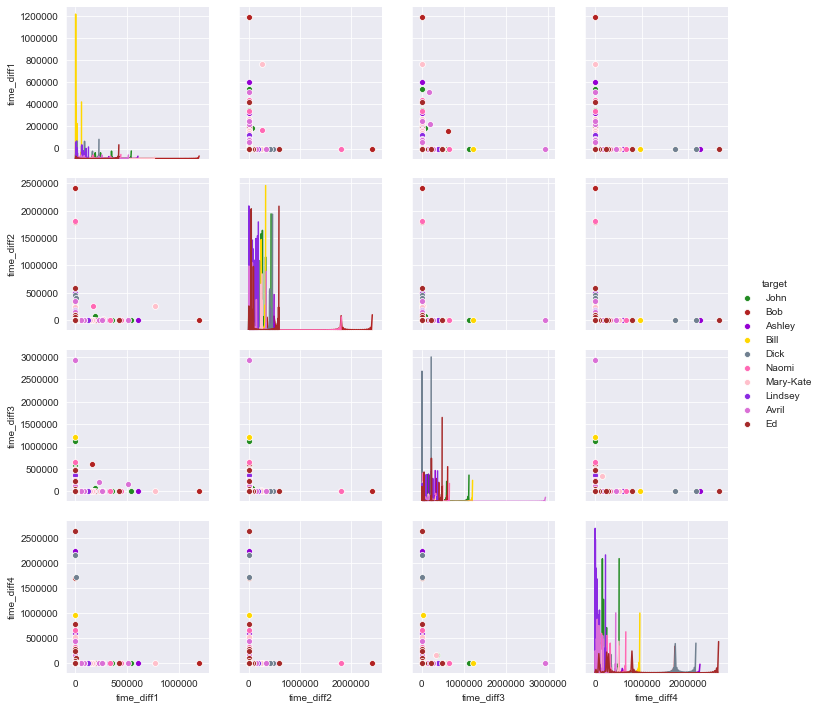

In [57]:
sub1 = ['time_diff' + str(i) for i in range(1,5)]
sns.pairplot(train10users_many_fe[sub1+['target']],hue='target',palette=color_dic, diag_kind="kde")

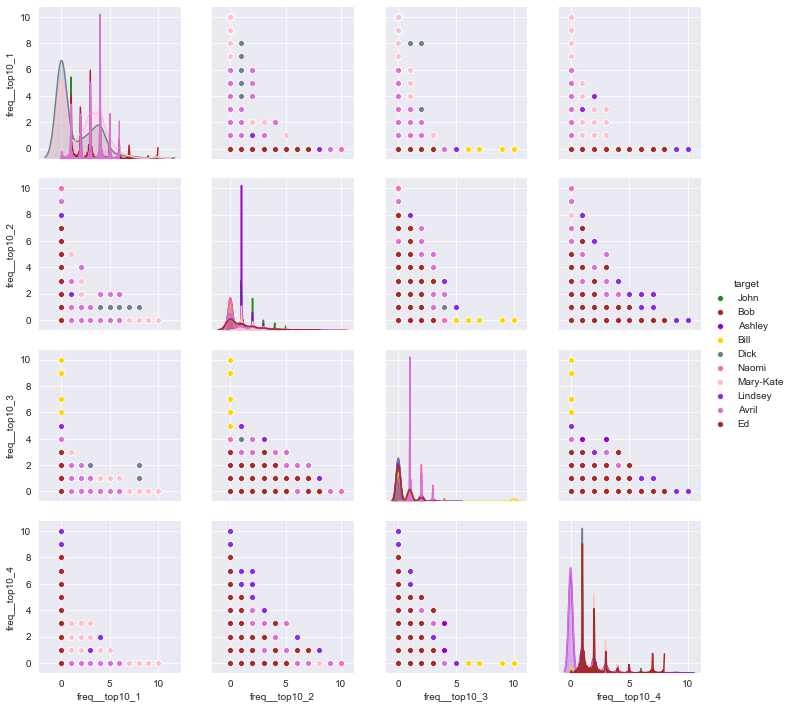

In [58]:
sub2 =  ['freq__top10_' + str(i) for i in range(1,5)]
sns.pairplot(train10users_many_fe[sub2+['target']],hue='target',palette=color_dic, diag_kind="kde")

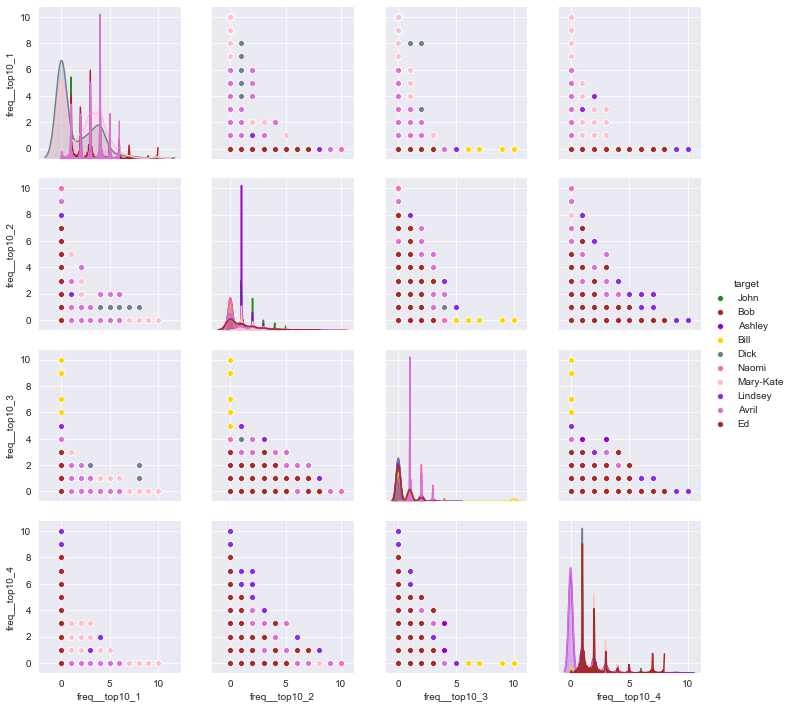

In [59]:
sub3 =  ['freq__top10_' + str(i) for i in range(1,5)]
sns.pairplot(train10users_many_fe[sub3+['target']],hue='target',palette=color_dic, diag_kind="kde")

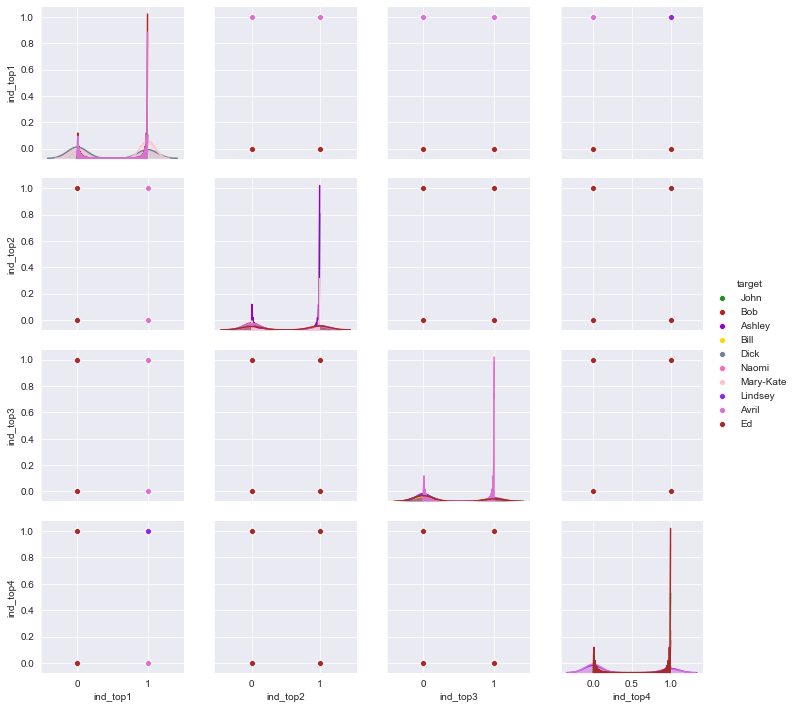

In [60]:
sub4 = ['ind_top'+str(i) for i in range(1,5)]
sns.pairplot(train10users_many_fe[sub4+['target']],hue='target',palette=color_dic, diag_kind="kde")

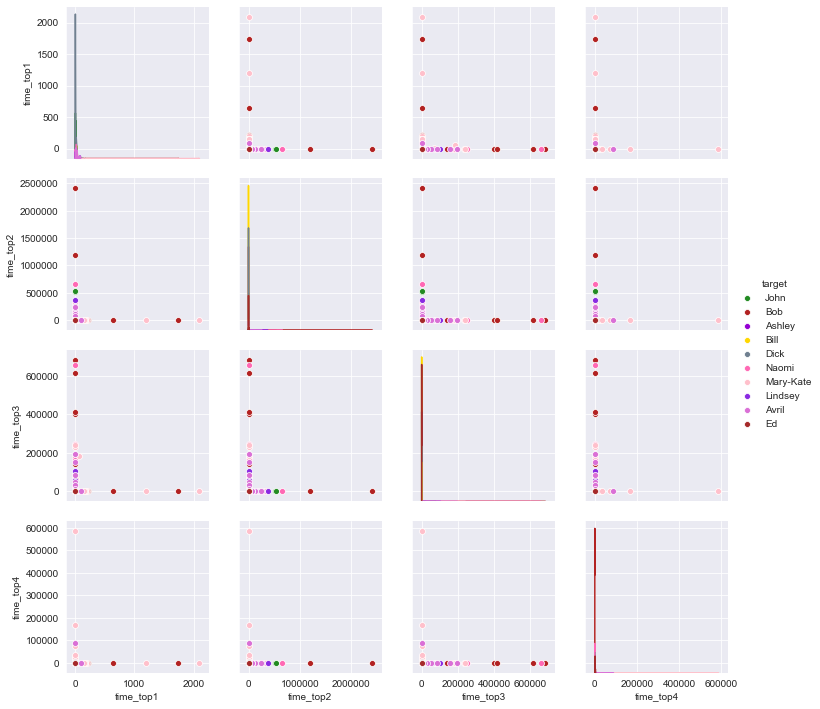

In [61]:
sub5 = ['time_top'+str(i) for i in range(1,5)]
sns.pairplot(train10users_many_fe[sub5+['target']],hue='target',palette=color_dic, diag_kind="kde")

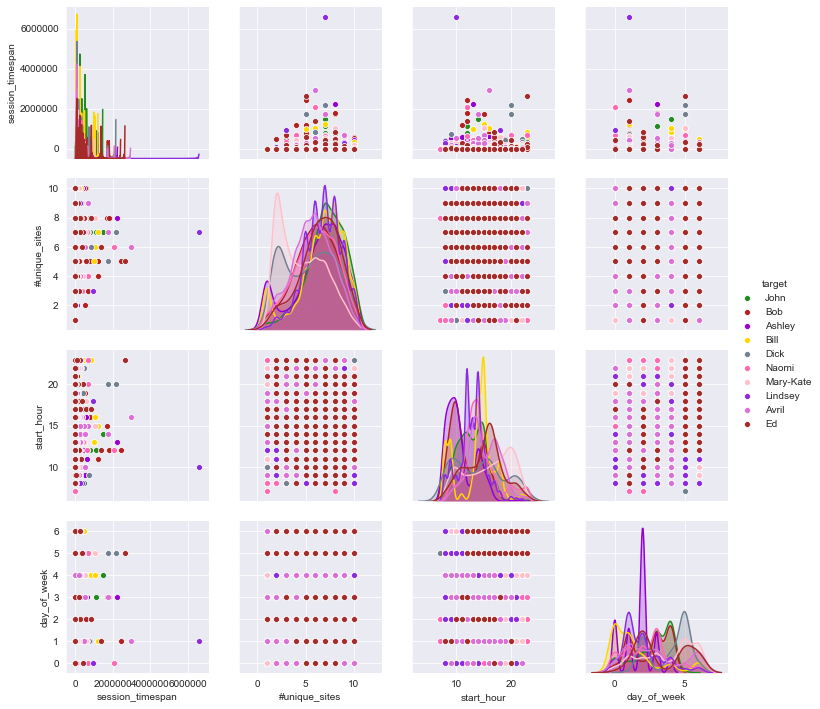

In [62]:
sub6 = ['session_timespan', '#unique_sites', 'start_hour','day_of_week']
sns.pairplot(train10users_many_fe[sub6+['target']],hue='target',palette=color_dic, diag_kind="kde")


Анализируя полученные графики, отмечу,что

**1.** Заметны разные распределения признаков для различных пользователей.

**2.** По некоторым признакам матрицы очень разрежены, трудно что-то сказать без дальнейшего анализа.

**3.** На некоторых scatterplot видны что-то вроде скоплений точек - хороший знак с точки зрения разделимости классов.

Необходим дальнейший анализ.

Сначала проверим, насколько сбалансированы классы.

**График интерактивный**

In [51]:
from plotly.offline import iplot
import plotly.graph_objs as go

number = []
users = []
for (user, sub_df) in  train10users_many_fe.groupby('target'): 
    number.append(sub_df.shape[0]) 
    users.append(user)
    
trace = go.Bar(
    x = users,
    y = number
)
layout = go.Layout(
    title='Количество сессий в зависимости от пользователя',
    
)

fig = go.Figure(data = [trace], layout = layout)
fig.update_layout(plot_bgcolor='white')
fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='#e9e9e9')
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='#e9e9e9')
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')

fig.data[0].marker.line.color = "black"
fig.data[0].marker.color = "LightSeaGreen"
fig.data[0].hoverlabel.bgcolor = "white"



iplot(fig)
print(sum(number))

14061


Количество сессий распределено неравномерно по пользователям. 

Проанализируем зависимость средних значений новых признаков от пользователя.

**Для переключения между признаками можно пользоваться виджетом.**

In [63]:
from __future__ import print_function
from ipywidgets import interactive
import ipywidgets as widgets

def f(num):
    plt.figure(figsize=(10,7))
    sns.barplot(users,train10users_many_fe.groupby('target')['time_diff'+str(num)].mean(),palette = color_dic)
    plt.ylabel('Среднее время за сессию')
    plt.title(f'Средние значения для времени просмотра {num} сайта из сессии')    
    plt.grid(True)
    plt.show()

interactive_plot = interactive(f, num=widgets.IntSlider(min=1, max=9, step=1, value=1))
interactive_plot

interactive(children=(IntSlider(value=1, description='num', max=9, min=1), Output()), _dom_classes=('widget-in…

In [64]:
def f2(num):
    plt.figure(figsize=(10,7))
    sns.barplot(users,train10users_many_fe.groupby('target')['freq__top10_'+str(num)].mean(),palette = color_dic)
    plt.ylabel('Средняя частота за сессию')
    plt.title(f'Средняя частота просмотра сайта {num} за сессию из топ 10 сайтов')    
    plt.grid(True)
    plt.show()

interactive_plot = interactive(f2, num=widgets.IntSlider(min=1, max=10, step=1, value=1))
interactive_plot

interactive(children=(IntSlider(value=1, description='num', max=10, min=1), Output()), _dom_classes=('widget-i…

In [65]:
def f3(num):
    plt.figure(figsize=(10,7))
    sns.barplot(users,train10users_many_fe.groupby('target')['freq__mid10_'+str(num)].mean(),palette = color_dic)
    plt.ylabel('Средняя частота за сессию')
    plt.title(f'Средняя частота просмотра сайта {num} за сессию из 10 менее популярных сайтов')    
    plt.grid(True)
    plt.show()

interactive_plot = interactive(f3, num=widgets.IntSlider(min=1, max=10, step=1, value=1))
interactive_plot

interactive(children=(IntSlider(value=1, description='num', max=10, min=1), Output()), _dom_classes=('widget-i…

In [66]:
def f4(num):
    plt.figure(figsize=(10,7))
    sns.barplot(users,train10users_many_fe.groupby('target')['time_top'+str(num)].mean(),palette = color_dic)
    plt.ylabel('Среднее время за сессию')
    plt.title(f'Средние значения для времени просмотра сайта {num} из топ 30 сайтов')    
    plt.grid(True)
    plt.show()

interactive_plot = interactive(f4, num=widgets.IntSlider(min=1, max=30, step=1, value=1))
interactive_plot

interactive(children=(IntSlider(value=1, description='num', max=30, min=1), Output()), _dom_classes=('widget-i…

Анализ средних значений вышеуказанных признаков показывает, что они сильно зависят от пользователя и, вероятно, могут помочь в его идентификации.

Ниже будут построены гистограммы для анализа распределений признаков по сессиям для различных пользователей

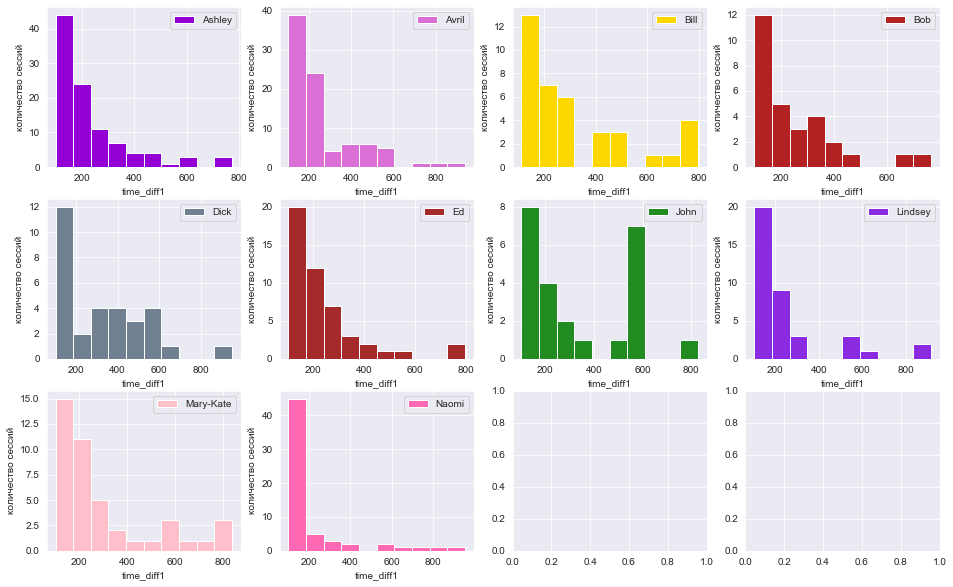

In [76]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))


for idx, (user, sub_df) in  enumerate(train10users_many_fe.groupby('target')): 
    ax = axes[idx//4,idx%4]    
    ax.hist(sub_df[sub_df.time_diff1<1000][sub_df.time_diff1>100].time_diff1,color = color_dic[user])
    ax.set(xlabel='time_diff1',ylabel='количество сессий')
    
    ax.grid(True)
    ax.legend([user])

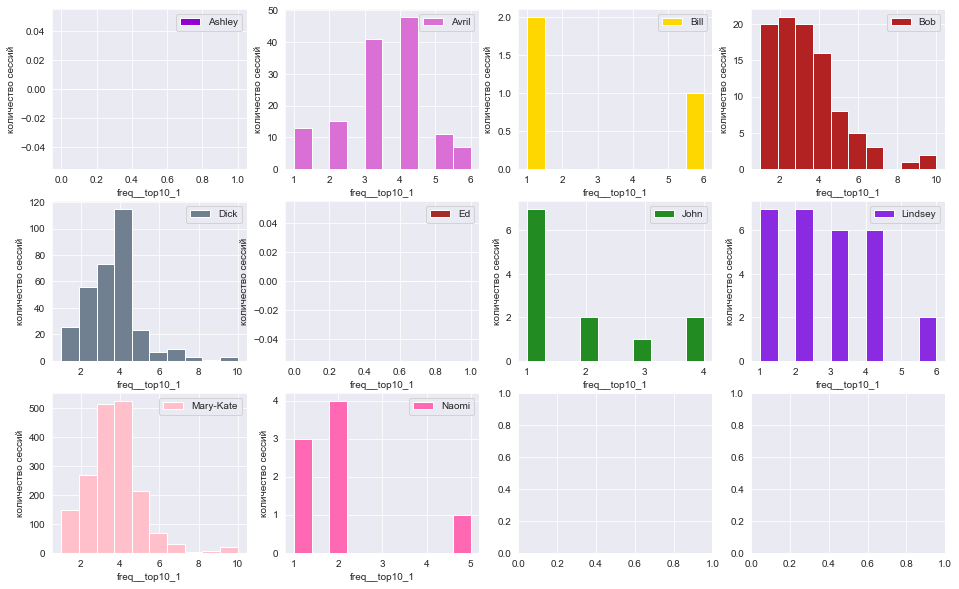

In [68]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))


for idx, (user, sub_df) in  enumerate(train10users_many_fe.groupby('target')): 
    ax = axes[idx//4,idx%4]    
    ax.hist(sub_df[sub_df.freq__top10_1>0].freq__top10_1,color = color_dic[user])
    ax.set(xlabel='freq__top10_1',ylabel='количество сессий')
    
    ax.grid(True)
    ax.legend([user])

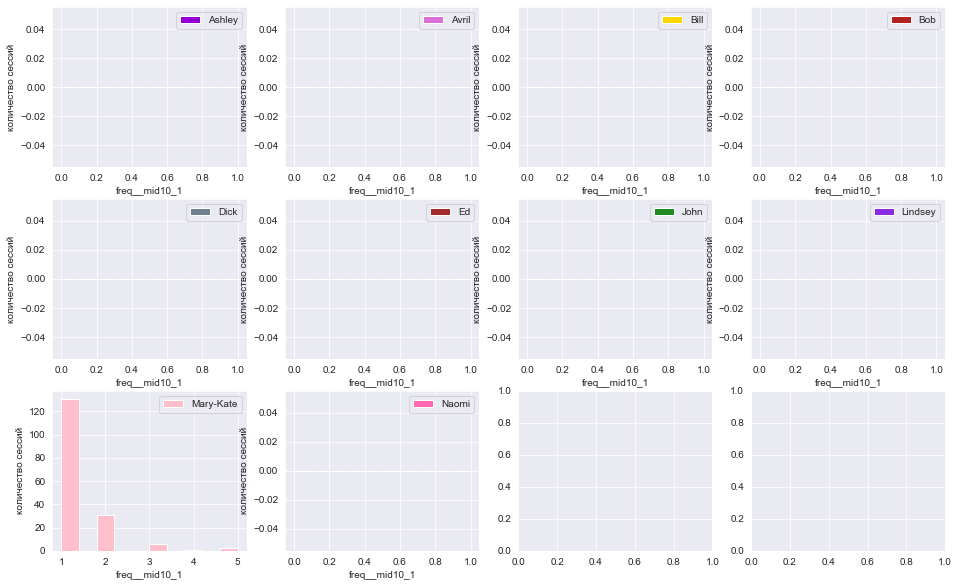

In [69]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))


for idx, (user, sub_df) in  enumerate(train10users_many_fe.groupby('target')): 
    ax = axes[idx//4,idx%4]    
    ax.hist(sub_df[sub_df.freq__mid10_1>0].freq__mid10_1,color = color_dic[user])
    ax.set(xlabel='freq__mid10_1',ylabel='количество сессий')
    
    ax.grid(True)
    ax.legend([user])

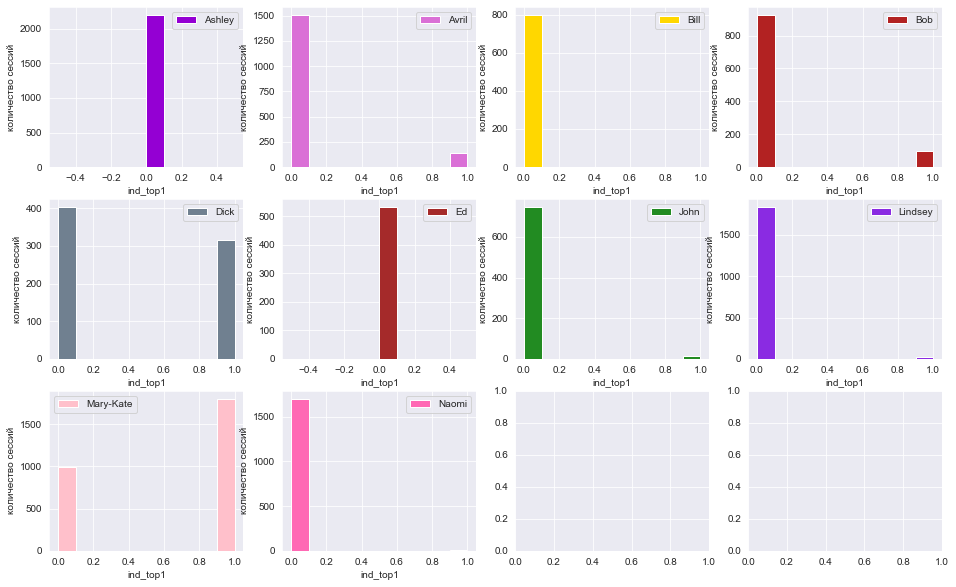

In [70]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))


for idx, (user, sub_df) in  enumerate(train10users_many_fe.groupby('target')): 
    ax = axes[idx//4,idx%4]    
    ax.hist(sub_df.ind_top1,color = color_dic[user])
    ax.set(xlabel='ind_top1',ylabel='количество сессий')
    
    ax.grid(True)
    ax.legend([user])

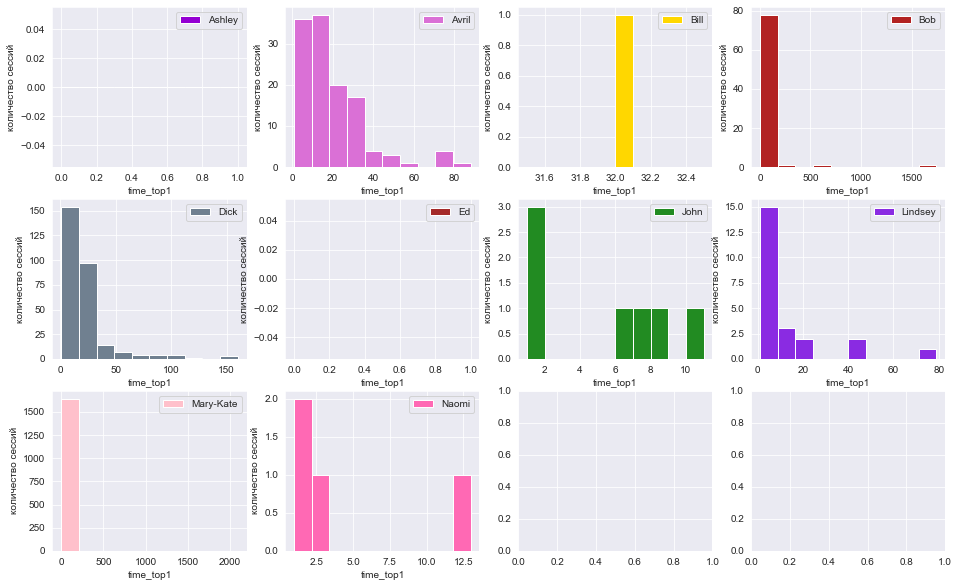

In [73]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))


for idx, (user, sub_df) in  enumerate(train10users_many_fe.groupby('target')): 
    ax = axes[idx//4,idx%4]    
    ax.hist(sub_df[sub_df.time_top1>0].time_top1,color = color_dic[user])
    ax.set(xlabel='time_top1',ylabel='количество сессий')
    
    ax.grid(True)
    ax.legend([user])

По приведенным выше гистограммам видно, что распределения признаков отличаются для разных пользователей, следовательно, предположительно, подобранные признаки могут помочь разделить классы в предстоящей задаче классификации. 

Для анализа эффективности разделения классов по новым признакам воспользуемся методом нелинейного понижения размерности признакового пространства t-SNE и попробуем визуализировать данные на плоскости.

In [77]:
from sklearn.manifold import TSNE

В качестве расстояния будет евклидовое расстояние.

In [78]:
X_new_dim = TSNE(n_components=2,random_state=42).fit_transform(new_features_10users.values)
X_new_dim.shape

(14061, 2)

In [79]:
df_new_dim_feat = pd.DataFrame(X_new_dim,columns=['feat1','feat2'])
df_new_dim =pd.concat([df_new_dim_feat,train10users_many_fe.target],axis=1) 
df_new_dim.head()

feat1      feat2 target
0   3.595891  10.598288   John
1 -15.615279  52.824436   John
2 -62.408848  34.866871   John
3   4.422143  11.206335   John
4  51.495708   0.307125   John

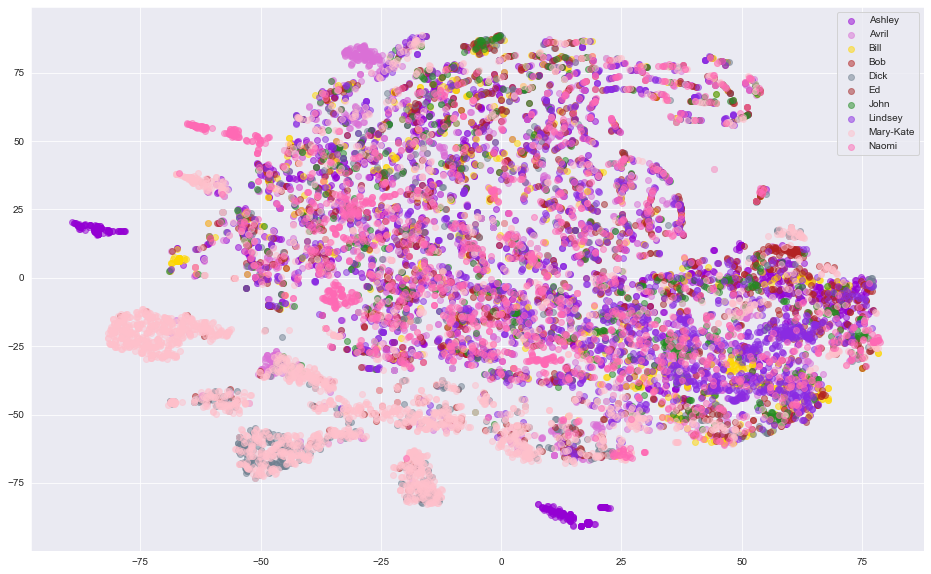

In [80]:
plt.figure(figsize=(16,10))
   
for (user,sub_df) in df_new_dim.groupby('target'):
    plt.scatter(sub_df.feat1,sub_df.feat2,color = color_dic[user],alpha=0.5,label=user)
plt.legend()
plt.show()

Посмотрим на каждого пользователя в отдельности

In [81]:
def funk(num):
    plt.figure(figsize=(16,10))
    sub_df = df_new_dim[df_new_dim.target == users[num-1]]
    plt.scatter(sub_df.feat1,sub_df.feat2,color = color_dic[users[num-1]],alpha=0.3) 
    plt.legend([users[num-1]])
    plt.grid(True)
    plt.show()

interactive_plot = interactive(funk, num=widgets.IntSlider(min=1, max=10, step=1, value=1))
interactive_plot

interactive(children=(IntSlider(value=1, description='num', max=10, min=1), Output()), _dom_classes=('widget-i…

Попробуем в качестве метрики использовать косинусную.

In [82]:
X_new_dim_cos = TSNE(n_components=2,random_state=42,metric ='cosine').fit_transform(new_features_10users.values)
X_new_dim_cos.shape

(14061, 2)

In [83]:
df_new_dim_feat_cos = pd.DataFrame(X_new_dim_cos,columns=['feat1','feat2'])
df_new_dim_cos =pd.concat([df_new_dim_feat_cos,train10users_many_fe.target],axis=1) 
df_new_dim_cos.head()

feat1      feat2 target
0 -28.272921  -6.335464   John
1 -25.194073  12.567287   John
2 -19.007315   6.507438   John
3 -34.704216  -1.510172   John
4  53.116341 -24.799292   John

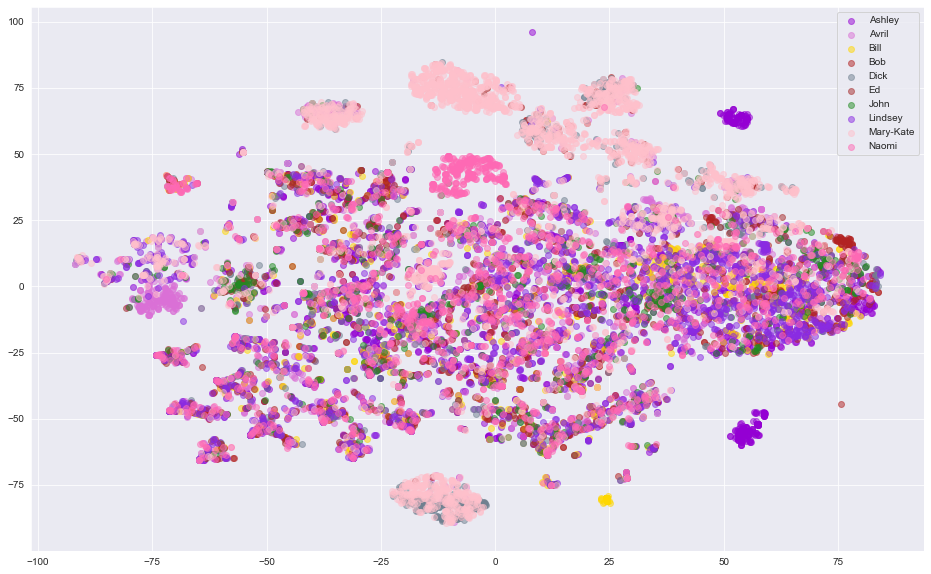

In [84]:
plt.figure(figsize=(16,10))
   
for (user,sub_df) in df_new_dim_cos.groupby('target'):
    plt.scatter(sub_df.feat1,sub_df.feat2,color = color_dic[user],alpha=0.5,label=user)
plt.legend()
plt.show()

Посмотрим на каждого пользователя в отдельности

In [85]:
def funk2(num):
    plt.figure(figsize=(16,10))
    sub_df = df_new_dim_cos[df_new_dim_cos.target == users[num-1]]
    plt.scatter(sub_df.feat1,sub_df.feat2,color = color_dic[users[num-1]],alpha=0.3) 
    plt.legend([users[num-1]])
    plt.grid(True)
    plt.show()

interactive_plot = interactive(funk2, num=widgets.IntSlider(min=1, max=10, step=1, value=1))
interactive_plot

interactive(children=(IntSlider(value=1, description='num', max=10, min=1), Output()), _dom_classes=('widget-i…

Видно, что при использовании ТОЛЬКО новых признаков и уменьшения размерности признакового пространства почти в 50 раз, классы, конечно, не разделяются на плоскости, но можно заметить высокую дисперсию распределения точек, соответствующих объектам сессий, на плоскости (много информации о классе), а также ярко выраженные скопления отдельных классов. Если присмотреться, можно заметить несильно выраженное направление, вдоль которого изменяются классы (на первой картинке - слева направо). Предположительно, данные признаки могут помочь в улучшении качества модели.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [86]:
selected_features_10users = new_features_10users
selected_features_150users = new_features_150users 

In [87]:
with open(os.path.join(PATH_TO_result, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_result, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 